In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
from monai.apps.utils import download_url
from monai.transforms import LoadImage
from monai.transforms.utility.dictionary import CoordinateTransformd

axial_path = "./spleen_60_axial.mrk.json"
coronal_path = "./spleen_60_coronal.mrk.json"
sagittal_path = "./spleen_60_sagittal.mrk.json"
# download_url("https://drive.google.com/uc?id=1zv57rnoPi0tP8w14KvX818XgaYuAJ6c3", axial_path)
# download_url("https://drive.google.com/uc?id=1f_xRQ2qGfCeG4GgYjX2NlJpuAmo0NBNi", coronal_path)
# download_url("https://drive.google.com/uc?id=1dQmKLw3IwyaSXwzxUqrNrx4o7vTqd22-", sagittal_path)
with open(axial_path, 'r') as file:
    data_axial = json.load(file)
with open(coronal_path, 'r') as file:
    data_coronal = json.load(file)
with open(sagittal_path, 'r') as file:
    data_sagittal = json.load(file)

coordinates_image_axial = np.array([
    [198, 202, 78],
    [187, 178, 78],
    [157, 156, 78],
    [138, 137, 78],
    [81, 185, 78],
    [75, 264, 78],
    [94, 238, 78],
    [115, 206, 78],
    [150, 204, 78],
    [192, 208, 78],
])

coordinates_image_coronal = np.array([
    [315, 205, 74],
    [305, 205, 70],
    [309, 205, 64],
    [328, 205, 66],
    [323, 205, 62],
    [319, 205, 58],
    [363, 205, 53],
    [385, 205, 59],
    [385, 205, 66],
    [352, 205, 72],
])

coordinates_image_sagittal = np.array([
    [187, 174, 74],
    [187, 166, 68],
    [187, 181, 64],
    [187, 219, 67],
    [187, 215, 72],
    [187, 188, 74],
])

# download the image from: https://drive.google.com/file/d/1HV6bUMDXbzJEyhBRpHVsPD62LUn6W8V1/view?usp=sharing
image_path = "/workspace/Data/Task09_Spleen/imagesTr/spleen_60.nii.gz"
image = LoadImage(image_only=True, reader="ITKReader")(image_path)

coordinates_world_axial = np.array([i['position'] for i in data_axial['markups'][0]['controlPoints']])
coordinates_world_coronal = np.array([i['position'] for i in data_coronal['markups'][0]['controlPoints']])
coordinates_world_sagittal = np.array([i['position'] for i in data_sagittal['markups'][0]['controlPoints']])

data = {
    "coordinates_image_axial": coordinates_image_axial[None],
    "coordinates_image_coronal": coordinates_image_coronal[None],
    "coordinates_image_sagittal": coordinates_image_sagittal[None],
    "coordinates_world_axial": coordinates_world_axial[None],
    "coordinates_world_coronal": coordinates_world_coronal[None],
    "coordinates_world_sagittal": coordinates_world_sagittal[None],
    "image": image,
}

COORD_IMAGE = ["coordinates_image_axial", "coordinates_image_coronal", "coordinates_image_sagittal"]
COORD_WORLD = ["coordinates_world_axial", "coordinates_world_coronal", "coordinates_world_sagittal"]

## CoordinateTransformd

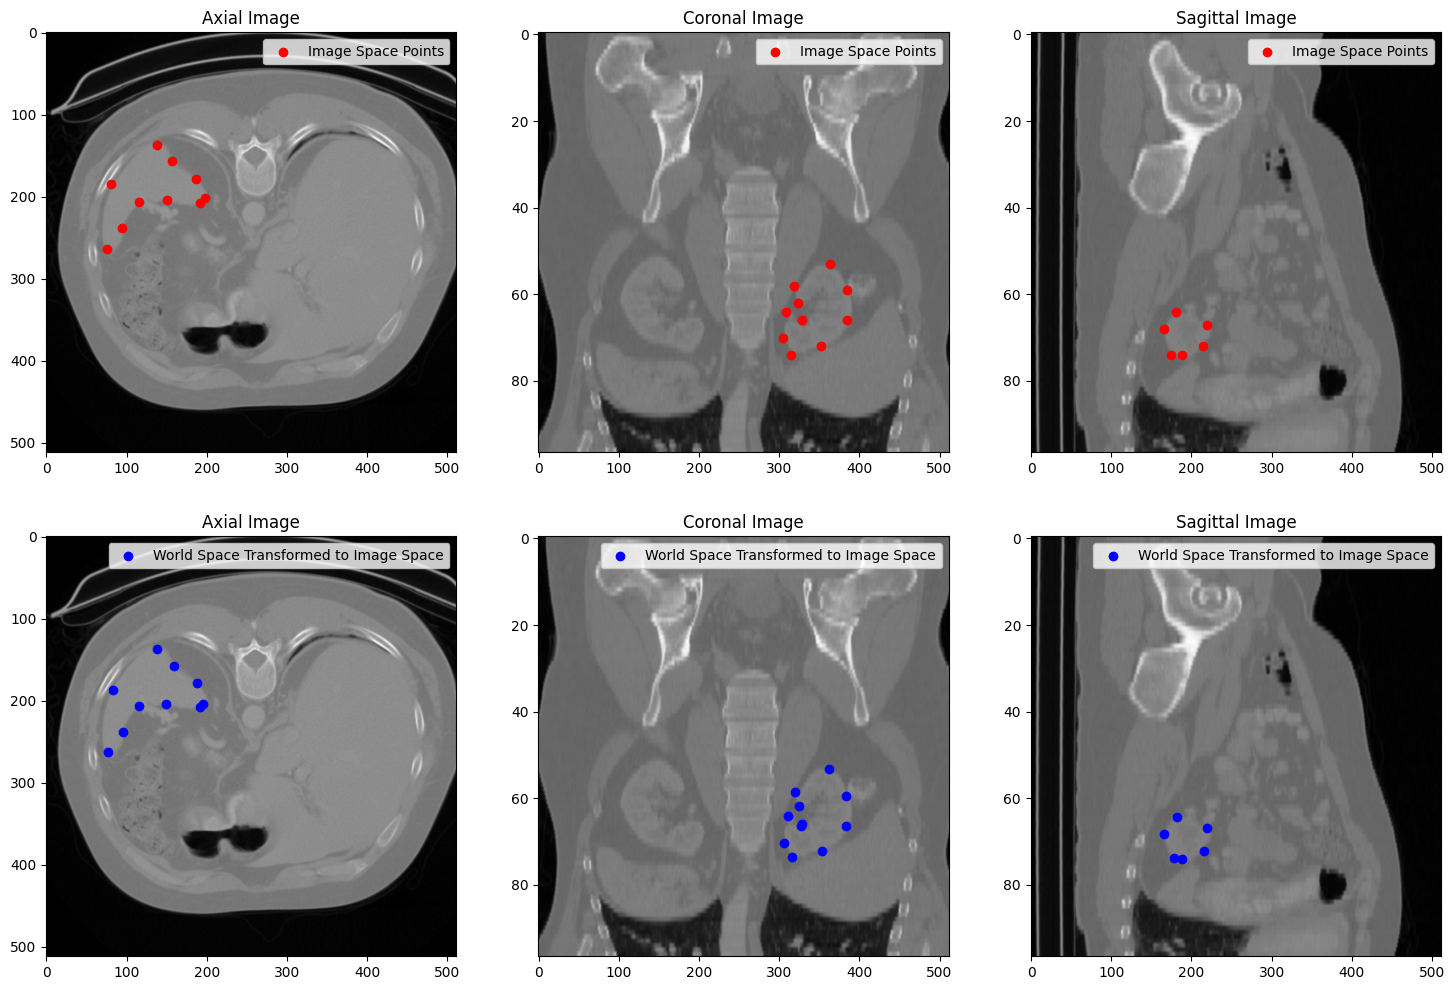

In [23]:
image_to_world_transform = CoordinateTransformd(keys=COORD_IMAGE, refer_key="image", mode='image_to_world')
world_to_image_transform = CoordinateTransformd(keys=COORD_WORLD, refer_key="image", mode='world_to_image', affine_lps_to_ras=True)

world_points_transformed_axial = image_to_world_transform(data)["coordinates_image_axial"]
world_points_transformed_coronal = image_to_world_transform(data)["coordinates_image_coronal"]
world_points_transformed_sagittal = image_to_world_transform(data)["coordinates_image_sagittal"]
out = world_to_image_transform(data)
image_points_transformed_axial = world_to_image_transform(data)["coordinates_world_axial"][0]
image_points_transformed_coronal = world_to_image_transform(data)["coordinates_world_coronal"][0]
image_points_transformed_sagittal = world_to_image_transform(data)["coordinates_world_sagittal"][0]

# visualize the points
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

def plt_ax(ax, image, coordinates, color, title, label):
    ax.imshow(image.T, cmap='gray', aspect='auto')
    ax.scatter(coordinates[0], coordinates[1], c=color, label=label)
    ax.set_title(title)
    ax.legend()


plt_ax(ax[0, 0], image[:, :, 78], (coordinates_image_axial[:, 0], coordinates_image_axial[:, 1]), 'r', 'Axial Image', 'Image Space Points')
plt_ax(ax[0, 1], image[:, 205, :], (coordinates_image_coronal[:, 0], coordinates_image_coronal[:, 2]), 'r', 'Coronal Image', 'Image Space Points')
plt_ax(ax[0, 2], image[187, :, :], (coordinates_image_sagittal[:, 1], coordinates_image_sagittal[:, 2]), 'r', 'Sagittal Image', 'Image Space Points')
plt_ax(ax[1, 0], image[:, :, 78], (image_points_transformed_axial[:, 0], image_points_transformed_axial[:, 1]), 'b', 'Axial Image', 'World Space Transformed to Image Space')
plt_ax(ax[1, 1], image[:, 205, :], (image_points_transformed_coronal[:, 0], image_points_transformed_coronal[:, 2]), 'b', 'Coronal Image', 'World Space Transformed to Image Space')
plt_ax(ax[1, 2], image[187, :, :], (image_points_transformed_sagittal[:, 1], image_points_transformed_sagittal[:, 2]), 'b', 'Sagittal Image', 'World Space Transformed to Image Space')

plt.show()

In [24]:
# invert it back to world space

out = world_to_image_transform.inverse(out)
print( coordinates_world_axial - out["coordinates_world_axial"] )

[[[-2.84217094e-14 -2.84217094e-14  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -5.68434189e-14  0.00000000e+00]
  [-5.68434189e-14 -5.68434189e-14  0.00000000e+00]
  [ 0.00000000e+00 -5.68434189e-14  0.00000000e+00]
  [ 0.00000000e+00 -2.84217094e-14  0.00000000e+00]
  [ 0.00000000e+00 -2.84217094e-14  0.00000000e+00]
  [ 0.00000000e+00 -5.68434189e-14  0.00000000e+00]
  [-5.68434189e-14 -5.68434189e-14  0.00000000e+00]
  [ 0.00000000e+00 -2.84217094e-14  0.00000000e+00]]]


## Add Flip transform

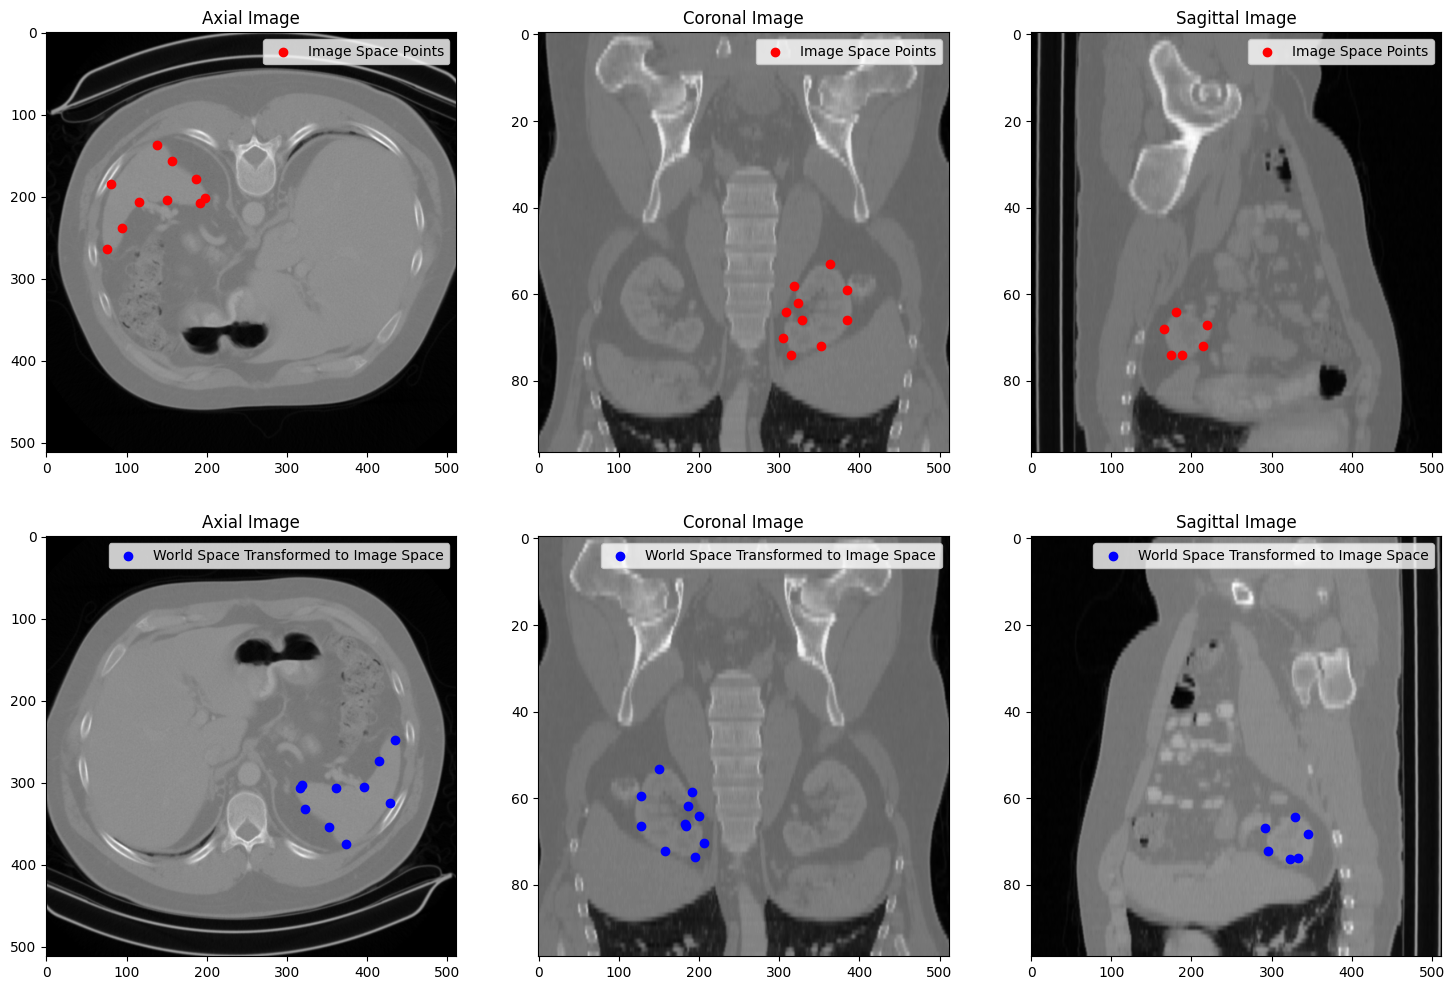

In [31]:
from monai.transforms import LoadImaged, Compose, Flipd
from monai.transforms.utility.dictionary import CoordinateTransformd
import matplotlib.pyplot as plt

data["image"] = image_path
world_to_image_transform = Compose([
    LoadImaged(keys="image", image_only=True, reader="ITKReader", ensure_channel_first=True),
    Flipd(keys="image", spatial_axis=[0, 1]),
    CoordinateTransformd(keys=COORD_WORLD, refer_key="image", mode='world_to_image', affine_lps_to_ras=True)
])

image_to_world_transform = Compose([
    LoadImaged(keys="image", image_only=True, reader="ITKReader"),
    CoordinateTransformd(keys=COORD_IMAGE, refer_key="image", mode='image_to_world')
])

world_points_transformed_axial = image_to_world_transform(data)["coordinates_image_axial"]
world_points_transformed_coronal = image_to_world_transform(data)["coordinates_image_coronal"]
world_points_transformed_sagittal = image_to_world_transform(data)["coordinates_image_sagittal"]
out = world_to_image_transform(data)
image_points_transformed_axial = world_to_image_transform(data)["coordinates_world_axial"][0]
image_points_transformed_coronal = world_to_image_transform(data)["coordinates_world_coronal"][0]
image_points_transformed_sagittal = world_to_image_transform(data)["coordinates_world_sagittal"][0]

# visualize the points
fig, ax = plt.subplots(2, 3, figsize=(18, 12))


plt_ax(ax[0, 0], image[:, :, 78], (coordinates_image_axial[:, 0], coordinates_image_axial[:, 1]), 'r', 'Axial Image', 'Image Space Points')
plt_ax(ax[0, 1], image[:, 205, :], (coordinates_image_coronal[:, 0], coordinates_image_coronal[:, 2]), 'r', 'Coronal Image', 'Image Space Points')
plt_ax(ax[0, 2], image[187, :, :], (coordinates_image_sagittal[:, 1], coordinates_image_sagittal[:, 2]), 'r', 'Sagittal Image', 'Image Space Points')
plt_ax(ax[1, 0], out['image'][0][:, :, 78], (image_points_transformed_axial[:, 0], image_points_transformed_axial[:, 1]), 'b', 'Axial Image', 'World Space Transformed to Image Space')
plt_ax(ax[1, 1], out['image'][0][:, 306, :], (image_points_transformed_coronal[:, 0], image_points_transformed_coronal[:, 2]), 'b', 'Coronal Image', 'World Space Transformed to Image Space')
plt_ax(ax[1, 2], out['image'][0][187, :, :], (image_points_transformed_sagittal[:, 1], image_points_transformed_sagittal[:, 2]), 'b', 'Sagittal Image', 'World Space Transformed to Image Space')

plt.show()